In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# import datasets
sensorA_System1 = pd.read_csv("../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../RawData/Key by TestID.csv")

In [3]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [4]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [5]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [6]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [7]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [8]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [9]:
# Merge attributes with extracted cal and sample window

# Sensor A
A1_attributes = A1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A1_cal_window = A1_cal_window.reset_index()
A1_cal_window_binned = A1_attributes.merge(A1_cal_window, how = "inner", on = "TestID")
A1_sample_window = A1_sample_window.reset_index()
A1_sample_window_binned = A1_attributes.merge(A1_sample_window, how = "inner", on = "TestID")

A2_attributes = A2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A2_cal_window = A2_cal_window.reset_index()
A2_cal_window_binned = A2_attributes.merge(A2_cal_window, how = "inner", on = "TestID")
A2_sample_window = A2_sample_window.reset_index()
A2_sample_window_binned = A2_attributes.merge(A2_sample_window, how = "inner", on = "TestID")

# Sensor B
B1_attributes = B1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B1_cal_window = B1_cal_window.reset_index()
B1_cal_window_binned = B1_attributes.merge(B1_cal_window, how = "inner", on = "TestID")
B1_sample_window = B1_sample_window.reset_index()
B1_sample_window_binned = B1_attributes.merge(B1_sample_window, how = "inner", on = "TestID")

B2_attributes = B2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B2_cal_window = B2_cal_window.reset_index()
B2_cal_window_binned = B2_attributes.merge(B2_cal_window, how = "inner", on = "TestID")
B2_sample_window = B2_sample_window.reset_index()
B2_sample_window_binned = B2_attributes.merge(B2_sample_window, how = "inner", on = "TestID")

In [10]:
# Function to aggregate means across samples then calculate slope and se
def calculate_slopes_se(bin_obj, system_cal, labels):
    slopes = []
    std = []

    for i in labels:
        bin_filter = bin_obj.query("`{}` == @i".format(system_cal))
        bin_filter = bin_filter.drop(["TestID", "FluidType", "AmbientTemperature", "Fluid Temperature", "AgeOfCardInDaysAtTimeOfTest", system_cal], axis=1)
        agg_bin = bin_filter.mean()
        agg_bin = agg_bin.to_frame(name="mean").reset_index()

        agg_bin.reset_index(inplace=True)
        X = agg_bin['index']
        y = agg_bin['mean']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        slopes.append(model.params[1])
        std.append(model.bse[1])
    
    result = pd.DataFrame({'Slope': slopes, 'SE': std})
    return result

# **Card Age**

In [ ]:
# Making bins and adding df column of the bin
bins = [0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252]
labels = ['0-9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']

# Sensor A
A1_cal_window_binned['A1-cal-age'] = pd.cut(A1_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
A1_sample_window_binned['A1-sample-age'] = pd.cut(A1_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

A2_cal_window_binned['A2-cal-age'] = pd.cut(A2_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
A2_sample_window_binned['A2-sample-age'] = pd.cut(A2_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

# Sensor B
B1_cal_window_binned['B1-cal-age'] = pd.cut(B1_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
B1_sample_window_binned['B1-sample-age'] = pd.cut(B1_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

B2_cal_window_binned['B2-cal-age'] = pd.cut(B2_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
B2_sample_window_binned['B2-sample-age'] = pd.cut(B2_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

In [ ]:
# # calculate slope for each bin
# def slope(x):
#     return (x.max() - x.min()) / x.mean()

# A1_cal_bin_slope = A1_cal_window_binned.groupby('A1-cal-age')['AgeOfCardInDaysAtTimeOfTest'].agg(slope)
# A1_sample_bin_slope = A1_sample_window_binned.groupby('A1-sample-age')['AgeOfCardInDaysAtTimeOfTest'].agg(slope)

# A2_cal_bin_slope = A2_cal_window_binned.groupby('A2-cal-age')['AgeOfCardInDaysAtTimeOfTest'].agg(slope)
# A2_sample_bin_slope = A2_sample_window_binned.groupby('A2-sample-age')['AgeOfCardInDaysAtTimeOfTest'].agg(slope)

# print(A1_cal_bin_slope)
# print()
# print(A2_cal_bin_slope)
# print()
# print(A1_sample_bin_slope)
# print()
# print(A2_sample_bin_slope)

In [ ]:
# # plot slope for System 1 and System 2
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # cal window
# axes[0].plot(A1_cal_bin_slope)
# axes[0].plot(A2_cal_bin_slope)
# axes[0].set_xticks(range(len(labels)))  
# axes[0].set_xticklabels(labels = labels, rotation=45)
# axes[0].legend(["System 1", "System 2"])
# axes[0].set_title("Slope within cal window")

# # sample window
# axes[1].plot(A1_sample_bin_slope)
# axes[1].plot(A2_sample_bin_slope)
# axes[1].set_xticks(range(len(labels)))
# axes[1].set_xticklabels(labels = labels, rotation=45)
# axes[1].legend(["System 1", "System 2"])
# axes[1].set_title("Slope within sample window")

# plt.tight_layout()
# plt.show()

In [ ]:
# Slopes and SE - Sensor A
A1_cal = calculate_slopes_se(A1_cal_window_binned, "A1-cal-age", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "A1-sample-age", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "A2-cal-age", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "A2-sample-age", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
0-9,-0.006167,0.000012,-0.007658,0.000034,-0.011012,0.000096,-0.007373,0.000067
9-28,-0.002812,0.000010,0.003282,0.000013,-0.011105,0.000109,0.001438,0.000135
28-56,0.014418,0.000017,0.018167,0.000013,0.003826,0.000128,0.015167,0.000128
56-84,0.023225,0.000039,0.020604,0.000006,0.007879,0.000177,0.016480,0.000137
84-112,0.021514,0.000035,0.020576,0.000006,0.007033,0.000188,0.016928,0.000109
112-140,0.020769,0.000038,0.020164,0.000007,0.006071,0.000184,0.016647,0.000099
140-168,0.019234,0.000040,0.018648,0.000006,0.004381,0.000190,0.014963,0.000099
168-196,0.018131,0.000044,0.021983,0.000004,0.003531,0.000191,0.018746,0.000115
196-224,0.021195,0.000043,0.027566,0.000010,0.007057,0.000192,0.022471,0.000114
224-252,0.024732,0.000048,0.032866,0.000021,0.010183,0.000199,0.026918,0.000115


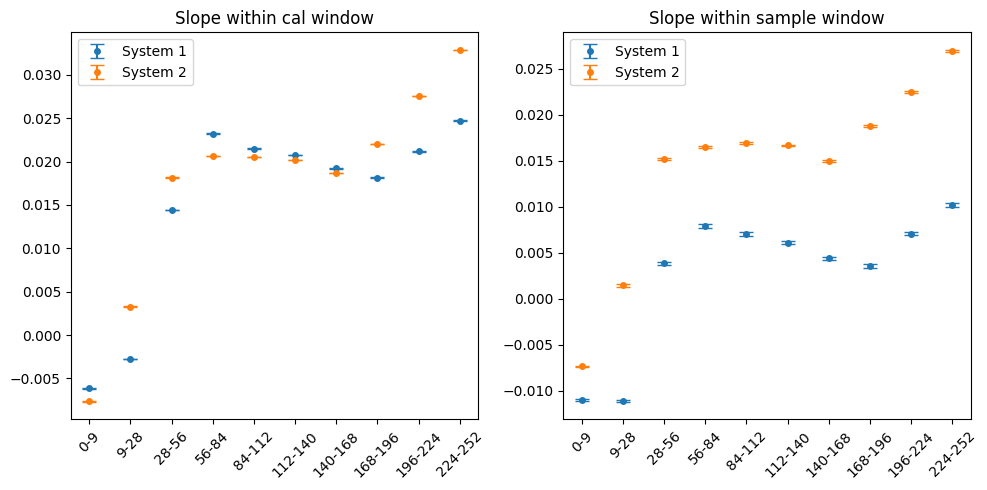

In [ ]:
# Plot of slopes - Sensor A
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [ ]:
# Slopes - Sensor B
B1_cal = calculate_slopes_se(B1_cal_window_binned, "B1-cal-age", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "B1-sample-age", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "B2-cal-age", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "B2-sample-age", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
0-9,0.043253,0.000024,0.048489,0.000041,0.045018,0.000082,0.051280,0.000082
9-28,0.024664,0.000019,0.037447,0.000044,0.033367,0.000207,0.040047,0.000121
28-56,0.033586,0.000031,0.040463,0.000047,0.035715,0.000155,0.043108,0.000149
56-84,0.040411,0.000052,0.041460,0.000052,0.039461,0.000171,0.044524,0.000184
84-112,0.039765,0.000052,0.041972,0.000040,0.036129,0.000144,0.043531,0.000160
112-140,0.038817,0.000052,0.040916,0.000042,0.033452,0.000130,0.039902,0.000146
140-168,0.035541,0.000049,0.039169,0.000039,0.031762,0.000135,0.040565,0.000150
168-196,0.035471,0.000051,0.044460,0.000054,0.034635,0.000146,0.045511,0.000177
196-224,0.033193,0.000047,0.046830,0.000058,0.033287,0.000161,0.045936,0.000166
224-252,0.036990,0.000051,0.048599,0.000067,0.037504,0.000161,0.046160,0.000162


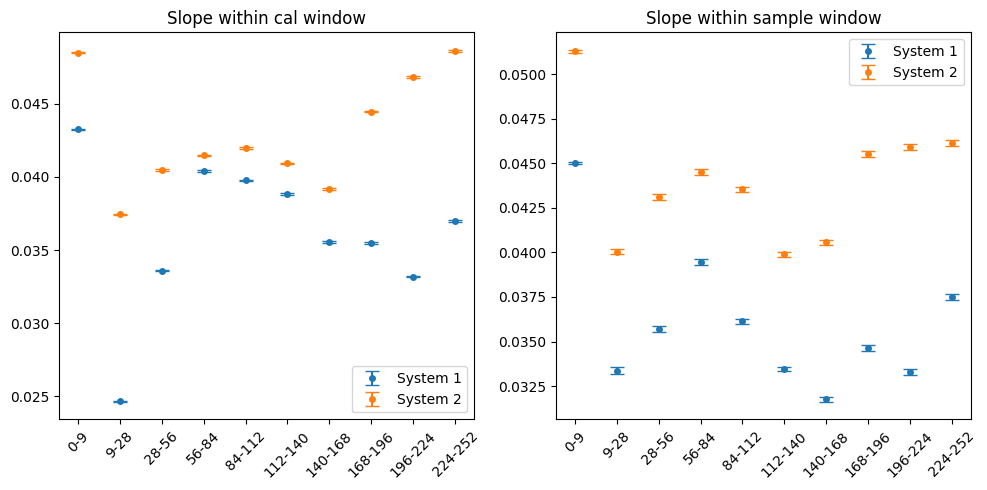

In [ ]:
# Plot of slopes - Sensor B
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [ ]:
# Drop binned column
A1_cal_window_binned = A1_cal_window_binned.drop("A1-cal-age", axis = 1)
A1_sample_window_binned = A1_sample_window_binned.drop("A1-sample-age", axis = 1)
A2_cal_window_binned = A2_cal_window_binned.drop("A2-cal-age", axis = 1)
A2_sample_window_binned = A2_sample_window_binned.drop("A2-sample-age", axis = 1)

B1_cal_window_binned = B1_cal_window_binned.drop("B1-cal-age", axis = 1)
B1_sample_window_binned = B1_sample_window_binned.drop("B1-sample-age", axis = 1)
B2_cal_window_binned = B2_cal_window_binned.drop("B2-cal-age", axis = 1)
B2_sample_window_binned = B2_sample_window_binned.drop("B2-sample-age", axis = 1)

# **Fluid Temperature**

In [ ]:
# If fluid temperature is NA, then copy Ambient Temperature into Fluid Temperature column

# A1 - cal window
for i in range(len(A1_cal_window_binned["Fluid Temperature"])):
    if np.isnan(A1_cal_window_binned["Fluid Temperature"].iloc[i]):
        A1_cal_window_binned.loc[i, "Fluid Temperature"] = A1_cal_window_binned["AmbientTemperature"].iloc[i]

# A1 - sample window
for i in range(len(A1_sample_window_binned["Fluid Temperature"])):
    if np.isnan(A1_sample_window_binned["Fluid Temperature"].iloc[i]):
        A1_sample_window_binned.loc[i, "Fluid Temperature"] = A1_sample_window_binned["AmbientTemperature"].iloc[i]

# A2 - cal window
for i in range(len(A2_cal_window_binned["Fluid Temperature"])):
    if np.isnan(A2_cal_window_binned["Fluid Temperature"].iloc[i]):
        A2_cal_window_binned.loc[i, "Fluid Temperature"] = A2_cal_window_binned["AmbientTemperature"].iloc[i]

# A2 - sample window
for i in range(len(A2_sample_window_binned["Fluid Temperature"])):
    if np.isnan(A2_sample_window_binned["Fluid Temperature"].iloc[i]):
        A2_sample_window_binned.loc[i, "Fluid Temperature"] = A2_sample_window_binned["AmbientTemperature"].iloc[i]

# B1 - cal window
for i in range(len(B1_cal_window_binned["Fluid Temperature"])):
    if np.isnan(B1_cal_window_binned["Fluid Temperature"].iloc[i]):
        B1_cal_window_binned.loc[i, "Fluid Temperature"] = B1_cal_window_binned["AmbientTemperature"].iloc[i]

# B1 - sample window
for i in range(len(B1_sample_window_binned["Fluid Temperature"])):
    if np.isnan(B1_sample_window_binned["Fluid Temperature"].iloc[i]):
        B1_sample_window_binned.loc[i, "Fluid Temperature"] = B1_sample_window_binned["AmbientTemperature"].iloc[i]

# B2 - cal window
for i in range(len(B2_cal_window_binned["Fluid Temperature"])):
    if np.isnan(B2_cal_window_binned["Fluid Temperature"].iloc[i]):
        B2_cal_window_binned.loc[i, "Fluid Temperature"] = B2_cal_window_binned["AmbientTemperature"].iloc[i]

# B2 - sample window
for i in range(len(B2_sample_window_binned["Fluid Temperature"])):
    if np.isnan(B2_sample_window_binned["Fluid Temperature"].iloc[i]):
        B2_sample_window_binned.loc[i, "Fluid Temperature"] = B2_sample_window_binned["AmbientTemperature"].iloc[i]

In [ ]:
# Making bins and adding df column of the bin
bins = [float('-inf'), 20, 26, float('inf')]
labels = ['Under 20C', '20-26C', 'Over 26C']

# Sensor A
A1_cal_window_binned['A1-cal-ft'] = pd.cut(A1_cal_window_binned['Fluid Temperature'], bins=bins, labels=labels)
A1_sample_window_binned['A1-sample-ft'] = pd.cut(A1_sample_window_binned['Fluid Temperature'], bins=bins, labels=labels)

A2_cal_window_binned['A2-cal-ft'] = pd.cut(A2_cal_window_binned['Fluid Temperature'], bins=bins, labels=labels)
A2_sample_window_binned['A2-sample-ft'] = pd.cut(A2_sample_window_binned['Fluid Temperature'], bins=bins, labels=labels)

# Sensor B
B1_cal_window_binned['B1-cal-ft'] = pd.cut(B1_cal_window_binned['Fluid Temperature'], bins=bins, labels=labels)
B1_sample_window_binned['B1-sample-ft'] = pd.cut(B1_sample_window_binned['Fluid Temperature'], bins=bins, labels=labels)

B2_cal_window_binned['B2-cal-ft'] = pd.cut(B2_cal_window_binned['Fluid Temperature'], bins=bins, labels=labels)
B2_sample_window_binned['B2-sample-ft'] = pd.cut(B2_sample_window_binned['Fluid Temperature'], bins=bins, labels=labels)

In [ ]:
# Slopes - Sensor A
A1_cal = calculate_slopes_se(A1_cal_window_binned, "A1-cal-ft", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "A1-sample-ft", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "A2-cal-ft", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "A2-sample-ft", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Under 20C,0.009161,0.000022,0.021364,0.000008,-0.003709,0.000169,0.017926,0.000260
20-26C,0.014312,0.000027,0.010319,0.000014,0.002287,0.000161,0.007967,0.000097
Over 26C,0.008064,0.000015,0.012193,0.000007,-0.002801,0.000101,0.010445,0.000055


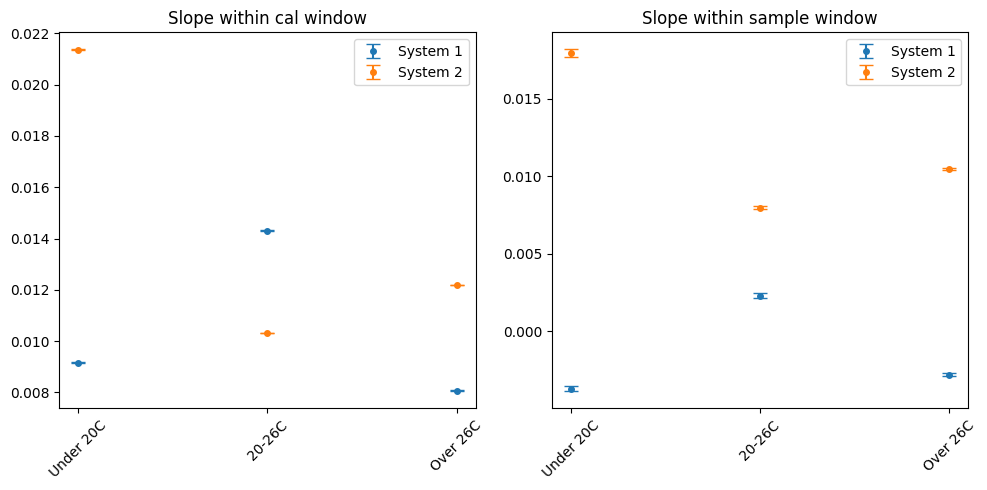

In [ ]:
# Plot of slopes - Sensor A
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [ ]:
# Slopes - Sensor B
B1_cal = calculate_slopes_se(B1_cal_window_binned, "B1-cal-ft", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "B1-sample-ft", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "B2-cal-ft", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "B2-sample-ft", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Under 20C,0.029264,0.000021,0.039620,0.000039,0.030143,0.000169,0.044122,0.000208
20-26C,0.037975,0.000043,0.045133,0.000046,0.037609,0.000138,0.046717,0.000130
Over 26C,0.026449,0.000016,0.041812,0.000046,0.026013,0.000134,0.043142,0.000135


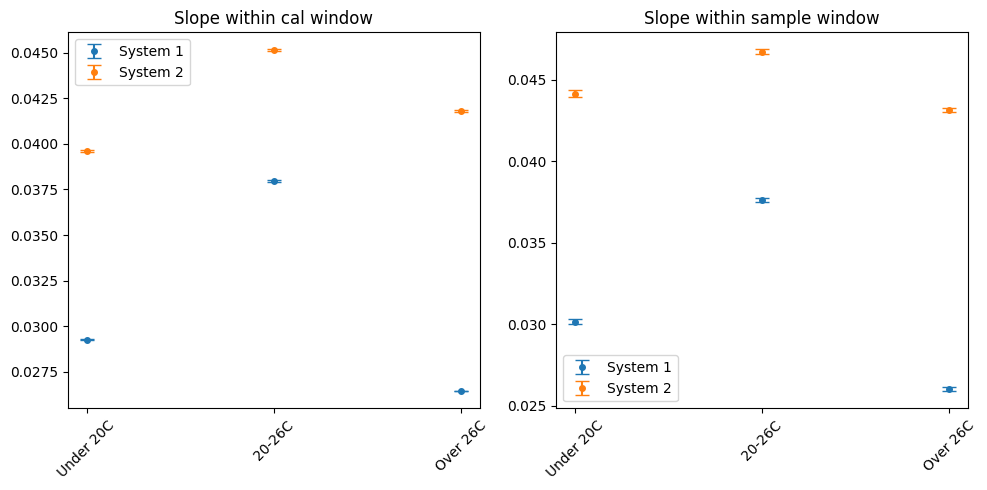

In [ ]:
# Plot of slopes - Sensor B
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [ ]:
# Drop binned column
A1_cal_window_binned = A1_cal_window_binned.drop("A1-cal-ft", axis = 1)
A1_sample_window_binned = A1_sample_window_binned.drop("A1-sample-ft", axis = 1)
A2_cal_window_binned = A2_cal_window_binned.drop("A2-cal-ft", axis = 1)
A2_sample_window_binned = A2_sample_window_binned.drop("A2-sample-ft", axis = 1)

B1_cal_window_binned = B1_cal_window_binned.drop("B1-cal-ft", axis = 1)
B1_sample_window_binned = B1_sample_window_binned.drop("B1-sample-ft", axis = 1)
B2_cal_window_binned = B2_cal_window_binned.drop("B2-cal-ft", axis = 1)
B2_sample_window_binned = B2_sample_window_binned.drop("B2-sample-ft", axis = 1)

# **Fluid Type**

In [14]:
A1_cal_window_binned

,TestID,AmbientTemperature,Fluid Temperature,FluidType,AgeOfCardInDaysAtTimeOfTest,0,1,2,3,4,...,31,32,33,34,35,36,37,38,39,40
0,12414200,20.9253,NaN,Eurotrol L3,7,56.742800,56.760980,56.740120,56.767830,56.745190,...,56.724030,56.705250,56.737140,56.715390,56.732970,56.730290,56.716280,56.722240,56.732370,56.720450
1,12414201,21.1005,NaN,Eurotrol L3,7,43.908820,43.919550,43.932070,43.958600,43.952050,...,44.173530,44.191410,44.184260,44.200050,44.196780,44.209000,44.223310,44.218240,44.247750,44.236130
2,12414202,20.9240,NaN,Eurotrol L3,7,59.229880,59.265350,59.251940,59.266240,59.273700,...,59.293370,59.286810,59.279660,59.287700,59.271610,59.273990,59.294260,59.290980,59.287410,59.279060
3,12414203,20.9240,NaN,Eurotrol L3,7,56.880650,56.860690,56.881550,56.877670,56.870820,...,56.950680,56.922970,56.925350,56.952470,56.926250,56.935190,56.932800,56.922070,56.928330,56.938470
4,12414204,20.9199,NaN,Eurotrol L3,7,65.799260,65.795980,65.796280,65.798360,65.798660,...,65.761410,65.764080,65.787930,65.765570,65.762890,65.787330,65.768850,65.769450,65.784940,65.781370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,12537663,21.9274,NaN,Eurotrol L4,88,8.024467,8.056956,8.093321,8.120445,8.155618,...,9.089771,9.131800,9.150578,9.185453,9.228077,9.238808,9.272788,9.315709,9.366084,9.394997
3378,12539049,22.6098,NaN,TB11,145,-19.179190,-19.159810,-19.125540,-19.111240,-19.089780,...,-18.482410,-18.452600,-18.434130,-18.412070,-18.381380,-18.374520,-18.331010,-18.349190,-18.298230,-18.284520
3379,12572832,20.8365,NaN,Eurotrol L4,201,-100.171800,-100.189900,-100.166700,-100.161600,-100.170600,...,-100.114300,-100.112800,-100.110700,-100.126200,-100.119900,-100.109500,-100.105600,-100.117800,-100.123800,-100.136000
3380,12572836,20.5732,NaN,Eurotrol L4,201,-7.987144,-7.987144,-7.969258,-7.966575,-7.941536,...,-7.513490,-7.472354,-7.449700,-7.474441,-7.434199,-7.416911,-7.389785,-7.394853,-7.392468,-7.364150


In [25]:
# Slopes - Sensor A
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
A1_cal = calculate_slopes_se(A1_cal_window_binned, "FluidType", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "FluidType", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "FluidType", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "FluidType", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.010366,0.000017,0.007642,0.000015,-0.000630,0.000138,0.006423,0.000123
Eurotrol L3,0.010634,0.000021,0.008187,0.000014,-0.000628,0.000166,0.005526,0.000099
Eurotrol L4,0.021483,0.000037,0.022422,0.000004,0.004963,0.000167,0.017728,0.000114
Eurotrol L5,0.012007,0.000026,0.005445,0.000017,-0.001689,0.000191,0.002824,0.000065
AB,-0.006141,0.000017,-0.007926,0.000043,-0.010200,0.000083,-0.006884,0.000066
HNB,0.017347,0.000035,0.014883,0.000018,0.006471,0.000159,0.013761,0.000116
NB,0.020807,0.000038,0.022699,0.000009,0.008606,0.000165,0.019267,0.000114
SB-3,0.015295,0.000030,0.018705,0.000024,0.000434,0.000100,0.006921,0.000153
DB,0.022293,0.000040,0.022582,0.000007,0.015647,0.000288,0.032312,0.000101
TB11,0.021898,0.000046,0.024530,0.000018,0.011716,0.000106,0.022371,0.000115


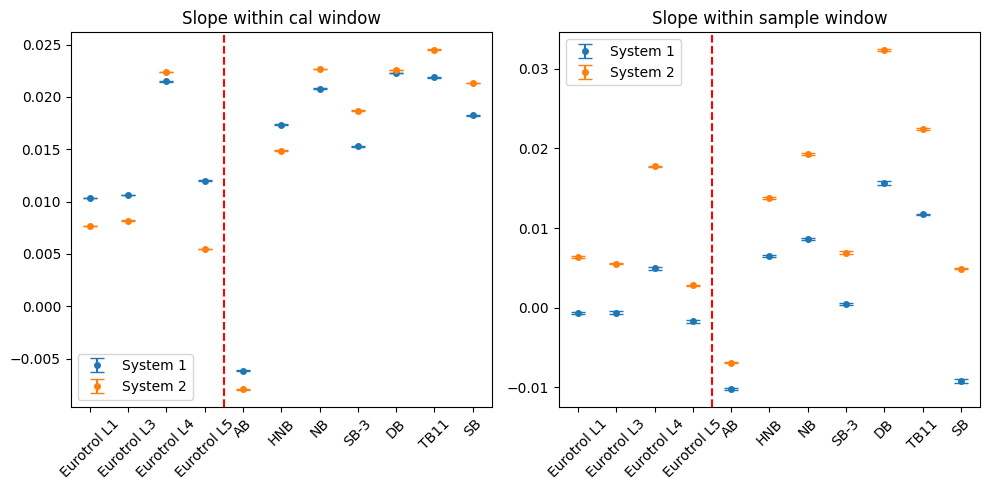

In [36]:
# Plot of slopes - Sensor A
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [26]:
# Slopes - Sensor B
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
B1_cal = calculate_slopes_se(B1_cal_window_binned, "FluidType", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "FluidType", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "FluidType", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "FluidType", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.036585,0.000035,0.044392,0.000044,0.050204,0.000292,0.058247,0.000281
Eurotrol L3,0.036775,0.000036,0.045007,0.000045,0.035858,0.000141,0.045654,0.000140
Eurotrol L4,0.037097,0.000048,0.042764,0.000054,0.049011,0.000297,0.055426,0.000304
Eurotrol L5,0.038749,0.000044,0.046179,0.000044,-0.008749,0.000366,0.019134,0.000300
AB,0.043204,0.000020,0.047938,0.000035,0.051884,0.000192,0.056812,0.000209
HNB,0.038287,0.000045,0.045391,0.000048,0.042657,0.000200,0.048749,0.000204
NB,0.036863,0.000050,0.043577,0.000052,0.041600,0.000195,0.049182,0.000214
SB-3,0.027915,0.000024,0.036499,0.000048,0.025839,0.000247,0.033135,0.000228
DB,0.036800,0.000049,0.043594,0.000056,0.034987,0.000029,0.049002,0.000077
TB11,0.037012,0.000055,0.043441,0.000055,0.045322,0.000161,0.056744,0.000214


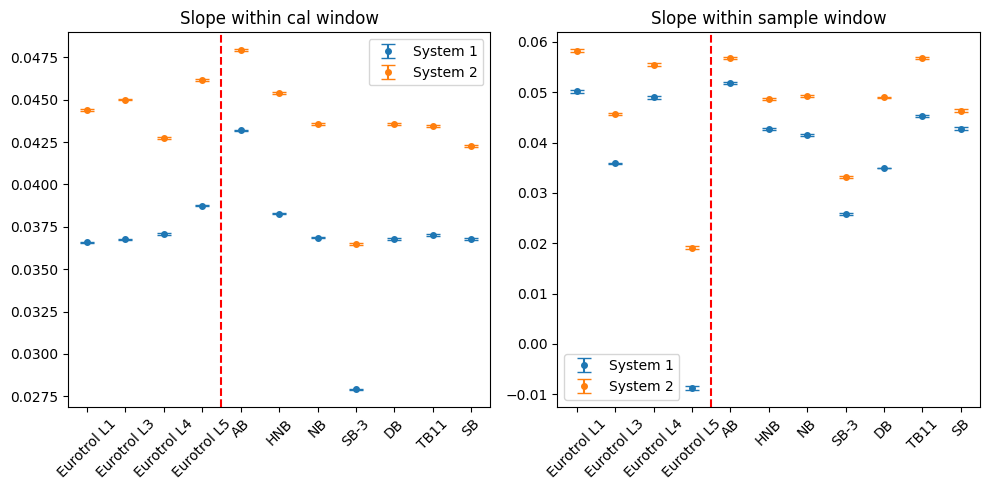

In [33]:
# Plot of slopes - Sensor B
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()